# Benchmark 

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

# from matplotlib import font_manager, rcParams
# custom_rc = {
#     'font.family': 'DejaVu Sans',
# }

# mpl.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['pdf.fonttype'] = 42

In [5]:
proj_name = "HypoMap_Steuernagel"
file_name = "HypoMap_Steuernagel"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [ ]:
# load the data
adata = sc.read_h5ad(data_dir / f"{file_name}.h5ad")

In [ ]:
adata

### preprocessing

In [ ]:
# ---------------------- Config ----------------------
MIN_GENES = 300
MIN_CELLS_PER_GENE = 5
N_TOP_HVG = 5000
N_PCS = 300

# ---------------------- Restart from Raw ----------------------
adata = adata.raw.to_adata()
print(f"✅ Restarted from raw: {adata.shape}")

# ---------------------- Add 'counts' Layer ----------------------
# Ensure integer counts and store them
if not np.issubdtype(adata.X.dtype, np.integer):
    adata.X = adata.X.astype("int32")
adata.layers["counts"] = adata.X.copy()

# ---------------------- QC Metrics ----------------------
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [ ]:
adata

In [ ]:
adata.obs['Batch_ID'].value_counts().to_dict()

In [ ]:
# ---------------------- Cell Filtering ----------------------
adata = adata[adata.obs.n_genes_by_counts > MIN_GENES, :]
adata.write(data_dir / f"{file_name}_preprocessed.h5ad")
adata.shape

In [ ]:
# ---------------------- Gene Filtering ----------------------
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_PER_GENE)
adata.shape

In [ ]:
# ---------------------- Set Filtered Raw ----------------------
adata.raw = adata.copy()

# ---------------------- Normalize & Log Transform ----------------------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ---------------------- Highly Variable Genes ----------------------
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=N_TOP_HVG,
    subset=False
)

# ---------------------- PCA ----------------------
sc.tl.pca(
    adata,
    n_comps=N_PCS,
    svd_solver='arpack',
    use_highly_variable=True
)

# ---------------------- Subset to HVGs ----------------------
adata = adata[:, adata.var.highly_variable].copy()
adata.write(data_dir / f"{file_name}_preprocessed_HVG.h5ad")  # after HVG subsetting

print(f"✅ Preprocessing complete: {adata.shape}. 'counts' saved in layers and raw.")

### run integration methods

In [ ]:
adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed_HVG.h5ad")

In [ ]:
adata

In [ ]:
import subprocess, json
methods = ["unintegrated", "harmony", "liger", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

# concord_args = {
#     "encoder_dims": [512, 256],
#     "beta": 0.1,
#     "n_epochs": 10
# }

output_dir = '../jobs'
device = 'auto'
conda_env = 'concord_env'
batch_key = 'Batch_ID'  # Use the same batch key as in the notebook  
state_key = 'cell_type'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args

mode = 'local'

subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed_HVG.h5ad",
    "--methods", *methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--mode", mode,
    # "--concord_kwargs", json.dumps(concord_args)
], check=True)

In [ ]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"
proj_folder.mkdir(parents=True, exist_ok=True)  # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"

with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — sequentially runs every benchmark Python file\n")
    f.write('cd "$(dirname "$0")"\n\n')

    f.write("source ~/.bashrc\n")
    f.write("conda activate concord_env\n\n")    
    f.write("timestamp=$(date +'%m%d-%H%M')\n\n")

    # Set the Python executable to use
    f.write('py_exec="${PYTHON_EXEC:-python}"\n\n')

    for py_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.py")):
        base = py_file.stem
        f.write(f"echo '🔄 Running: {py_file.name} (log: {base}_${{timestamp}}.log)'\n")
        f.write(f"${{py_exec}} {py_file.name} > {base}_${{timestamp}}.log 2>&1\n")
        f.write("echo '✅ Done.'\n\n")

submit_all.chmod(0o755)
print(f"📌  Next step: Run “{submit_all}” to execute all batch integration methods sequentially.")

In [ ]:
# Run “{submit_all}” to execute all batch integration methods sequentially.
!bash {submit_all}

----

In [ ]:
# load adata with genes without HVG selection
adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")

methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

In [ ]:
adata

In [ ]:
from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

In [ ]:
adata

In [ ]:
# save adata with all embeddings
adata.write_h5ad(data_dir / f"{file_name}_final.h5ad")

----

In [ ]:
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "contrastive"]

In [ ]:
# map the obsm back to the adata 
# for each method, uses the most recent run (based on timestamp)
# methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]

from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=methods)



In [ ]:
for method in methods:
    if f"{method}_UMAP" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 2D UMAP for {method}...")
        ccd.ul.run_umap(adata, source_key=f"{method}", result_key=f"{method}_UMAP", n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP'] computed")
    if f"{method}_UMAP_3D" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP_3D'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 3D UMAP for {method}...")
        ccd.ul.run_umap(adata,source_key=f"{method}",result_key=f"{method}_UMAP_3D",n_components=3,  min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP_3D'] computed")

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

In [ ]:
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=.1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'donor_id': 'Set1', 
       'cell_type': 'Set1'}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


In [ ]:
output_key = 'concord_hcl'
basis = output_key
show_basis = basis + '_UMAP'
show_cols = ['donor_id', 'cell_type']
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, figsize=(8,4), dpi=600, ncols=2, font_size=4, point_size=0.5, legend_loc='on data',
        pal = pal, seed=seed,
        save_path=save_dir / f"{show_basis}_{file_suffix}_wttext.pdf"
    )

In [ ]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

# Benchmarking

In [4]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

✅ Benchmark summary saved to: ../save/HypoMap_Steuernagel-Jul07-1715/benchmark_summary_Jul07-1715.tsv


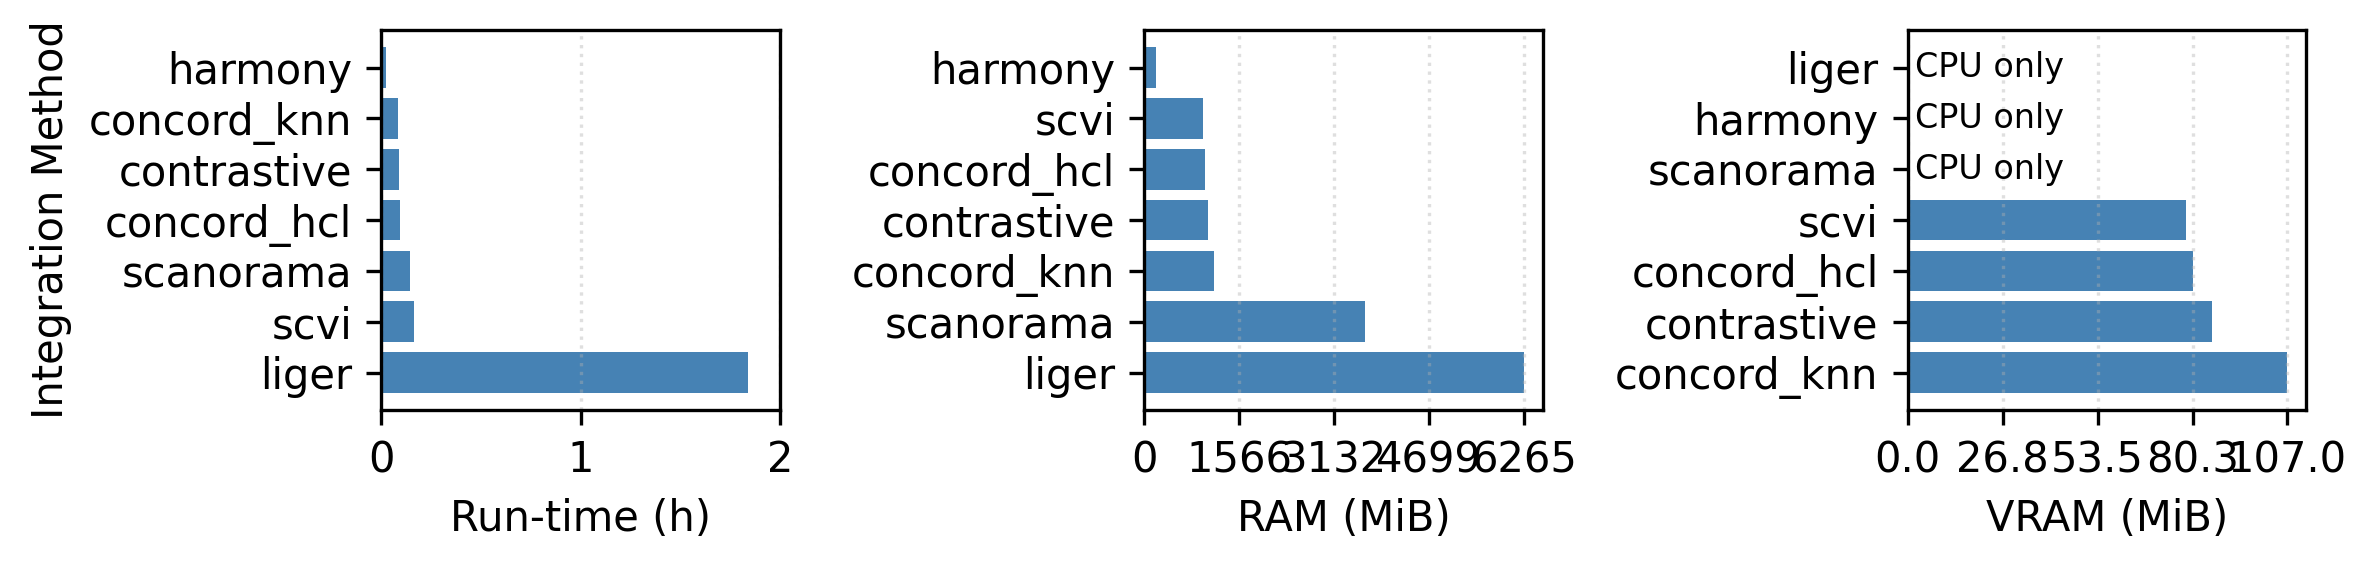

In [7]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs("HypoMap_Steuernagel", methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


In [ ]:
# Run the benchmark pipeline
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib","probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")